In [1]:
import os
import sys
sys.path.insert(0, os.path.join('..'))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import radial as rd
from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C, inbatch_parallel
from radial.batchflow.models.tf import ResNet18, Inception_v4, MobileNet_v2, ResNet34, VGG7, VGG19, TFModel
from radial.core import RadialBatch, concatenate_points
from radial.batchflow.research import Research, Option
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def show_research(df, layout=None, average_repetitions=False, log_scale=False, rolling_window=None):
    """Show plots given by research dataframe."""
    if layout is None:
        layout = []
        for nlabel, ndf in df.groupby("name"):
            ndf = ndf.drop(['config', 'name', 'iteration', 'repetition'], axis=1).dropna(axis=1)
            for attr in ndf.columns.values:
                layout.append('/'.join([str(nlabel), str(attr)]))
    if type(log_scale) is bool:
        log_scale = [log_scale] * len(layout)
    if (type(rolling_window) is int) or (rolling_window is None):
        rolling_window = [rolling_window] * len(layout)
    rolling_window = [x if x is not None else 1 for x in rolling_window]

    fig, ax = plt.subplots(1, len(layout), figsize=(9 * len(layout), 7))
    if len(layout) == 1:
        ax = (ax, )

    for i, (title, log, rw) in enumerate(list(zip(*[layout, log_scale, rolling_window]))):
        name, attr = title.split('/')
        ndf = df[df['name'] == name]
        for clabel, cdf in ndf.groupby("config"):
            cdf = cdf.drop(['config', 'name'], axis=1).dropna(axis=1).astype('float')
            if average_repetitions:
                idf = cdf.groupby('iteration').mean().drop('repetition', axis=1)
                y_values = idf[attr].rolling(rw).mean().values
                if log:
                    y_values = np.log(y_values)
                ax[i].plot(idf.index.values, y_values, label=str(clabel))
            else:
                for r, rdf in cdf.groupby('repetition'):
                    rdf = rdf.drop('repetition', axis=1)
                    y_values = rdf[attr].rolling(rw).mean().values
                    if log:
                        y_values = np.log(y_values)
                    ax[i].plot(rdf['iteration'].values, y_values,
                               label='/'.join([str(r), str(clabel)]))
        ax[i].set_xlabel('iteration')
        ax[i].set_title(title)
        ax[i].legend()
    plt.show()

In [3]:
N_SAMPLES = 1500

In [4]:
ix = FilesIndex(path='./data/*')
dset = Dataset(ix, RadialBatch)
dset.split()

In [5]:
rad_data_ppl = (Pipeline()
                    .load(fmt='npz')
                    .delete_outliers()
                    .get_samples(1500, sampler=np.random.random, sort=True)
)

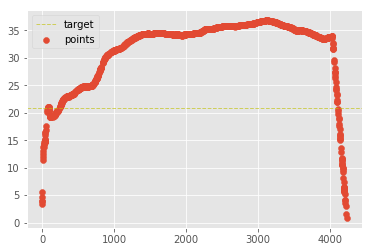

In [12]:
rad_ppl = rad_data_ppl << dset.train

a = rad_ppl.next_batch(1, shuffle=True)

plt.scatter(a.time[0], a.derivative[0], label='points')
plt.axhline(a.target[0], ls='--', c='y', lw=1, alpha=0.6, label='target')
plt.legend()

In [13]:
model_config = {
    'inputs': dict(points=dict(shape=(2, N_SAMPLES)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'loss': 'mse',
    'optimizer': C('optimizer')
}

In [8]:
train_pipeline = rad_data_ppl + (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', C('model'), 'point', config=model_config)
                  .train_model('point', fetches='loss', make_data=concatenate_points,
                               save_to=V('loss'), mode='w')
                  .run(50, n_epochs=None, drop_last=True, lazy=True)
) << dset.train

test_pipeline = rad_data_ppl + (Pipeline()
                .init_variable('predictions', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list)
                .import_model('point', C('import_from'))
                .update_variable('targets', B('target'), mode='e')
                .predict_model('point', fetches='predictions',
                                make_data=concatenate_points,
                                save_to=V('predictions'), mode='e')
                .run(50, n_epochs=1, drop_last=True, lazy=True)
) << dset.test

In [9]:
def get_mse(iteration, experiment, pipeline):
    """ Calculate mean squared error."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    y_pred = np.array(pipeline.get_variable('predictions')).reshape(-1)
    y_true = np.array(pipeline.get_variable('targets'))
    return mean_squared_error(y_true, y_pred)

def save_model(iteration, experiment, pipeline, model_name, path='./'):
    """ Save model to a path."""
    print(experiment[pipeline])
    path = os.path.join(path, experiment[pipeline].config.alias(as_string=True) + '_' + str(iteration))
    pipeline = experiment[pipeline].pipeline
    pipeline.save_model(model_name, path)
    return

In [10]:
momentum_dict = dict(name='Momentum', use_nesterov=True, learning_rate=0.1, momentum=0.5)
opts = Option('model', [ResNet18, Inception_v4, MobileNet_v2, ResNet34, VGG7, VGG19]) \
      * Option('optimizer', ['Adam',
                              momentum_dict,
                              momentum_dict.update(dict(learining_rate=.01)),
                              momentum_dict.update(dict(learining_rate=.001)), 'Adagrad'])
research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mse, returns='loss', name='test_mse',
                      execute='%5', pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                  model_name='point', path='saved_models/')
)

In [11]:
research_name = 'research'
research.run(n_reps=4, n_iters=1000, name=research_name, progress_bar=True)

Research research is starting...


  0%|          | 0/20 [00:00<?, ?it/s]

Distributor has 2 jobs with 10 iterations. Totally: 20


 50%|█████     | 10/20 [00:33<00:33,  3.36s/it]

100%|██████████| 20/20 [01:08<00:00,  3.42s/it]

100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


In [13]:
res = research.load('./research/')
df = research.load_results(use_alias=True)

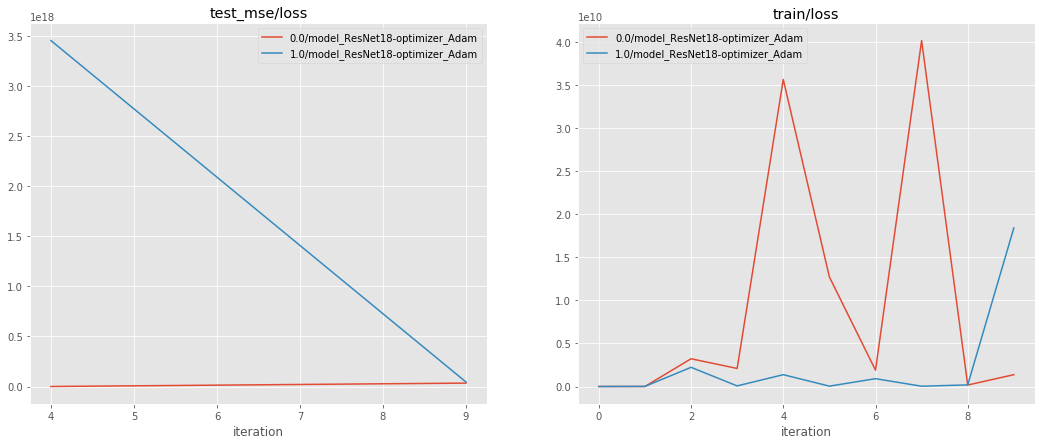

In [14]:
show_research(df)

In [16]:
pred_pipeline = (rad_data_ppl + (Pipeline()
                  .init_model('dynamic', TFModel, 
                             'points', 
                             config={'build': False,
                                     'load': {'path': 'saved_models/model_ResNet18-optimizer_Adam_9/'}})
                  .init_variable('predictions', init_on_each_run=list)
                  .init_variable('targets', init_on_each_run=list)
                  .update_variable('targets', B('target'), mode='e')
                  .init_variable('points', init_on_each_run=list)
                  .predict_model('points', fetches=['predictions', 'points'],
                                 make_data=concatenate_points,
                                 save_to=[V('predictions'), V('points')], mode='a'))) << dset.test

In [17]:
pred_pipeline.run(50, shuffle=True, n_epochs=1, drop_last=True, bar=True)

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from saved_models/model_ResNet18-optimizer_Adam_9/model-10


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


In [127]:
point = np.array(pred_pipeline.get_variable('points')).reshape(-1, 2, N_SAMPLES)
target = np.array(pred_pipeline.get_variable('targets'))
predictions = np.array(pred_pipeline.get_variable('predictions')).reshape(-1)

In [128]:
print("MSE: %.3f" % mean_squared_error(target, predictions))

MSE: 47142043708255896.000


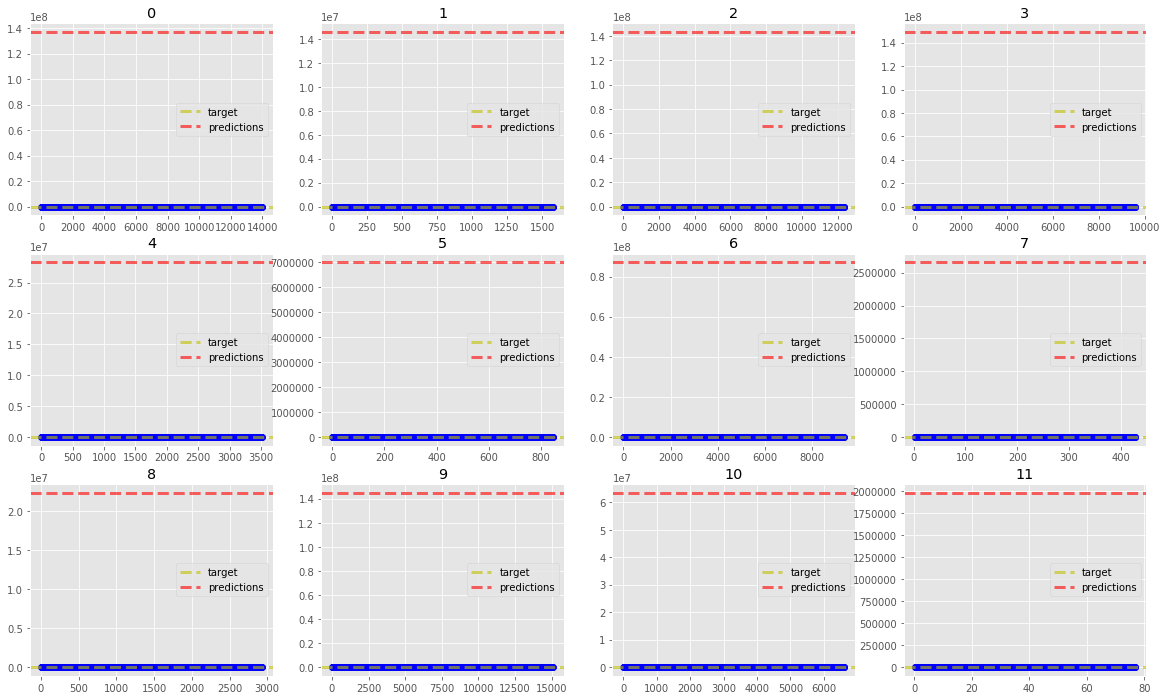

In [130]:
_, ax = plt.subplots(3, 4, figsize=(20, 12))
ax = ax.reshape(-1)
s = 0
for i in range(s, s+12):
    x = (point[i].T[:,0])
    y = (point[i].T[:,1])
    ax[i-s].scatter(x, y, c='b')
    ax[i-s].axhline(target[i], ls='--', c='y', lw=3, alpha=0.6, label='target')
    ax[i-s].axhline(predictions[i], ls='--', c='r', lw=3, alpha=0.6, label='predictions')
    ax[i-s].set_title('{}'.format(i))
    ax[i-s].legend()

# ЧТО-ТО СТРАННОЕ

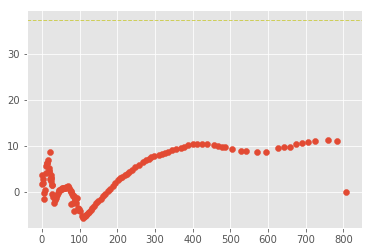

In [85]:
z = dict(np.load('./data/rr_374.npz'))

plt.scatter(z['time'], z['derivative'])
plt.axhline(z['target'], ls='--', c='y', lw=1, alpha=0.6, label='target')